## Surowe dane

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from pandas import json_normalize
%matplotlib notebook

In [2]:
with open('data_Dayton.json', 'r') as openfile:
    json_object = json.load(openfile)

df_reasons = pd.json_normalize(json_object, record_path = ['days'])


df_reasons.rename(columns = {'datetime':'date'}, inplace = True)

df_reasons = df_reasons.set_index('date')
df_reasons['daty'] = pd.to_datetime(df_reasons.index).date
print(df_reasons)
# print(type(df_reasons['daty'].values[0]))

            datetimeEpoch  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
date                                                                            
2004-01-01     1072933200      8.8     -2.9   4.0           6.1          -5.9   
2004-01-02     1073019600     14.4      7.2  10.8          14.4           4.1   
2004-01-03     1073106000     16.5      7.0  12.8          16.5           3.4   
2004-01-04     1073192400      6.5      2.3   3.4           3.5          -3.3   
2004-01-05     1073278800      3.0     -1.9  -0.4          -1.1          -7.9   
...                   ...      ...      ...   ...           ...           ...   
2018-12-27     1545886800     11.6      1.9   5.6          11.6          -1.6   
2018-12-28     1545973200     14.0      1.5  10.1          14.0          -3.4   
2018-12-29     1546059600      1.8      0.5   1.1           1.4          -4.5   
2018-12-30     1546146000      3.7     -2.0   0.9           0.5          -5.0   
2018-12-31     1546232400   

In [3]:
Energy_consumption_Dayton = pd.read_csv('Energy_consumption_Dayton.csv')
Energy_consumption_Dayton_original = Energy_consumption_Dayton
Energy_day_of_week = Energy_consumption_Dayton.copy()
# Energy_consumption_Dayton.set_index('Datetime', inplace=True)
print(Energy_consumption_Dayton_original)
#Energy_consumption_Dayton.info()


                   Datetime  Energy_MW
0       2004-12-31 01:00:00     1596.0
1       2004-12-31 02:00:00     1517.0
2       2004-12-31 03:00:00     1486.0
3       2004-12-31 04:00:00     1469.0
4       2004-12-31 05:00:00     1472.0
...                     ...        ...
121270  2018-01-01 20:00:00     2732.0
121271  2018-01-01 21:00:00     2724.0
121272  2018-01-01 22:00:00     2664.0
121273  2018-01-01 23:00:00     2614.0
121274  2018-01-02 00:00:00     2552.0

[121275 rows x 2 columns]


## Tworzenie Datasetu

Tworzenie datasetu z porami dnia (rano 7-14->1, popołudnie 15-22->2, noc 23-6->3)

In [4]:
df_energy = Energy_consumption_Dayton_original
df_energy['time'] = df_energy['Datetime'].str[-9:]
df_energy_time = df_energy.groupby(['time']).sum('Energy_MW')#.plot(rot=90)
# print('df_energy_time\n', df_energy_time)

df_energy['part_of_day'] = df_energy['Datetime'].str[-8:-6]
df_energy['part_of_day'] = df_energy['part_of_day'].astype(np.int64)
df_energy['part_of_day'] = df_energy['part_of_day'].replace({7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1,
                                                            15:2, 16:2, 17:2, 18:2, 19:2, 20:2, 21:2, 22:2,
                                                            23:3, 0:3, 1:3, 2:3, 3:3, 4:3, 5:3, 6:3})

print(df_energy)
# df_energy.info()

                   Datetime  Energy_MW       time  part_of_day
0       2004-12-31 01:00:00     1596.0   01:00:00            3
1       2004-12-31 02:00:00     1517.0   02:00:00            3
2       2004-12-31 03:00:00     1486.0   03:00:00            3
3       2004-12-31 04:00:00     1469.0   04:00:00            3
4       2004-12-31 05:00:00     1472.0   05:00:00            3
...                     ...        ...        ...          ...
121270  2018-01-01 20:00:00     2732.0   20:00:00            2
121271  2018-01-01 21:00:00     2724.0   21:00:00            2
121272  2018-01-01 22:00:00     2664.0   22:00:00            2
121273  2018-01-01 23:00:00     2614.0   23:00:00            3
121274  2018-01-02 00:00:00     2552.0   00:00:00            3

[121275 rows x 4 columns]


wykres przedstawia zużycie energi zależne od dni

In [5]:
df_energy = Energy_consumption_Dayton
df_energy = df_energy.set_index('Datetime')
df_energy['daty'] = pd.to_datetime(df_energy.index).date
df_energy_day = df_energy.groupby(['daty']).sum('Energy_MW')
df_energy_day = df_energy_day.loc[df_energy_day['Energy_MW'] >10000,:]
# print(df_energy_day)
df_energy_day_view = df_energy_day.copy()


połączenie danych zawierających Energie oraz czynniki które mogą na nią wpływać

In [6]:
df_merge_energy_reasons = pd.merge(df_reasons, df_energy_day, how = "inner", on = 'daty')
# print(df_merge_energy_reasons)


Wczytanie danych o Demografi w Dayton(dane pobrane z google(Link:https://www.google.com/search?client=opera-gx&q=demographics+dayton+ohio&sourceid=opera&ie=UTF-8&oe=UTF-8))


In [7]:
Dayton_population = pd.read_csv('dayton_population.csv')
Dayton_population = Dayton_population.set_index('Year')
Dayton_population = Dayton_population.reset_index()
#print(Dayton_population)

df_merge_energy_reasons['Year'] = df_merge_energy_reasons['daty'].astype(str).str[0:4]
df_merge_energy_reasons['Year'] = df_merge_energy_reasons['Year'].astype(np.int64)
#df_merge_energy_reasons.info()

df_merge_energy_reasons = pd.merge(df_merge_energy_reasons, Dayton_population, how = "inner", on = 'Year')
# print(df_merge_energy_reasons)

Wyciągniecie dnia tygodnia, miesiąca oraz pory roku

In [8]:
df_merge_energy_reasons['day_365'] = df_merge_energy_reasons['daty'].astype(str).str[5:11]


In [9]:
df_merge_energy_reasons = df_merge_energy_reasons.set_index('daty')
df_merge_energy_reasons['weekday'] = pd.to_datetime(df_merge_energy_reasons.index).day_of_week
df_merge_energy_reasons['month'] = pd.to_datetime(df_merge_energy_reasons.index).month
df_merge_energy_reasons['season'] = df_merge_energy_reasons['month']
df_merge_energy_reasons['season'] = df_merge_energy_reasons['season'].replace({1:4, 2:4, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3,10:3, 11:3,12:4 })

df_merge_energy_reasons.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5054 entries, 2004-10-01 to 2018-08-02
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetimeEpoch   5054 non-null   int64  
 1   tempmax         5054 non-null   float64
 2   tempmin         5054 non-null   float64
 3   temp            5054 non-null   float64
 4   feelslikemax    5054 non-null   float64
 5   feelslikemin    5054 non-null   float64
 6   feelslike       5054 non-null   float64
 7   dew             5054 non-null   float64
 8   humidity        5054 non-null   float64
 9   precip          5054 non-null   float64
 10  precipprob      0 non-null      object 
 11  precipcover     5054 non-null   float64
 12  preciptype      0 non-null      object 
 13  snow            1078 non-null   float64
 14  snowdepth       1460 non-null   float64
 15  windgust        2693 non-null   float64
 16  windspeed       5054 non-null   float64
 17  winddir         4325 no

## Wykresy

<IPython.core.display.Javascript object>


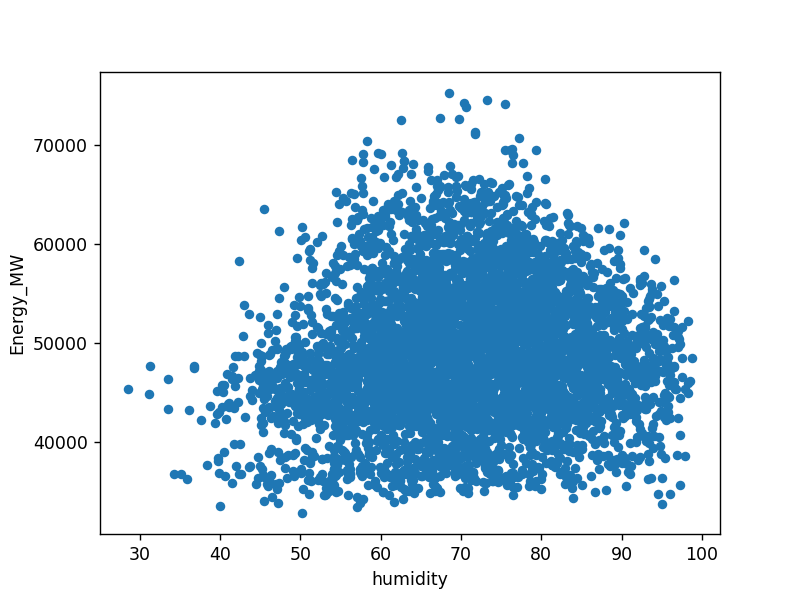

<AxesSubplot: xlabel='humidity', ylabel='Energy_MW'>

In [10]:
df_merge_energy_reasons.plot.scatter(x='humidity', y='Energy_MW')


<IPython.core.display.Javascript object>


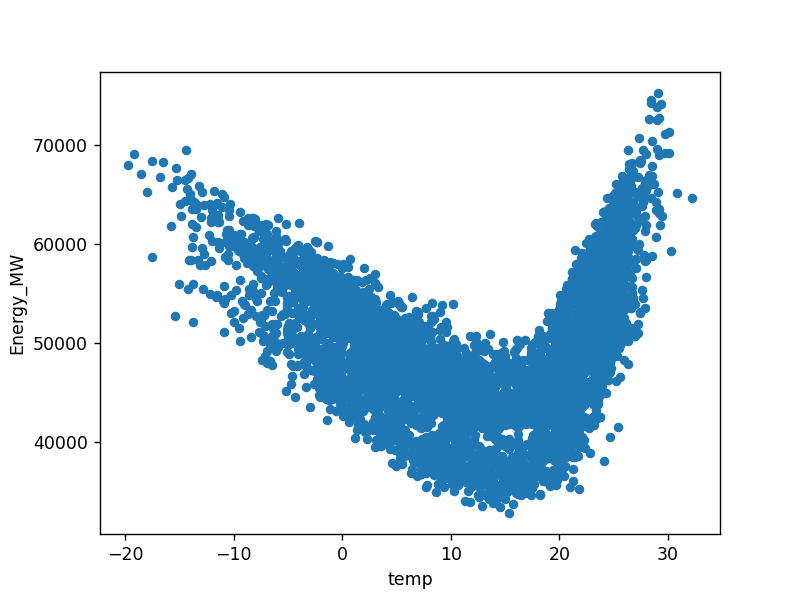

<AxesSubplot: xlabel='temp', ylabel='Energy_MW'>

In [11]:
df_merge_energy_reasons.plot.scatter(x='temp', y='Energy_MW')


Ewidętnie widać różnice w energi dla temeratur niskich (spowodowane najpewniej przez ogrzewanie) 
oraz wysokich(spowodowane przez klimatyzację)
Wartość średnia wynosi około 16 stopni

<IPython.core.display.Javascript object>


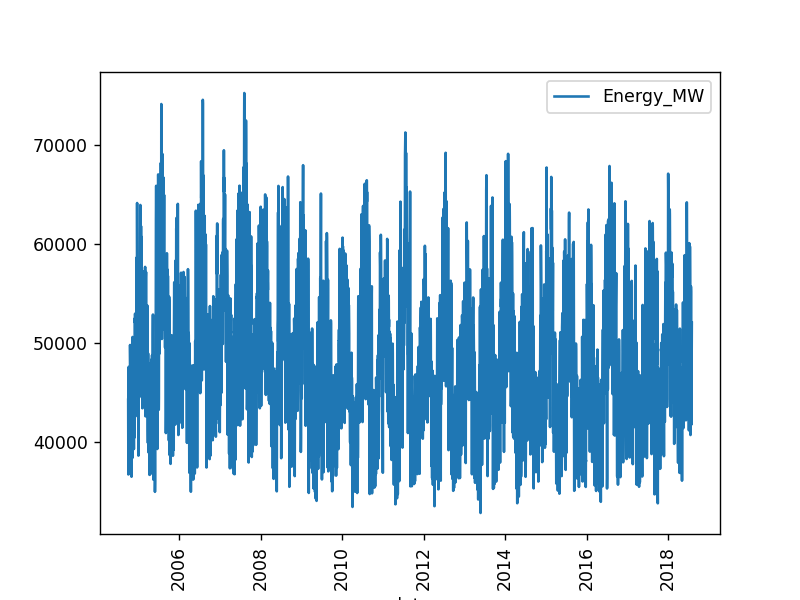

<AxesSubplot: xlabel='daty'>

In [12]:
df_energy_day_view = df_energy_day_view.drop(columns = 'part_of_day')
#print(df_energy_day_view)
df_energy_day_view.plot(rot=90)

<IPython.core.display.Javascript object>


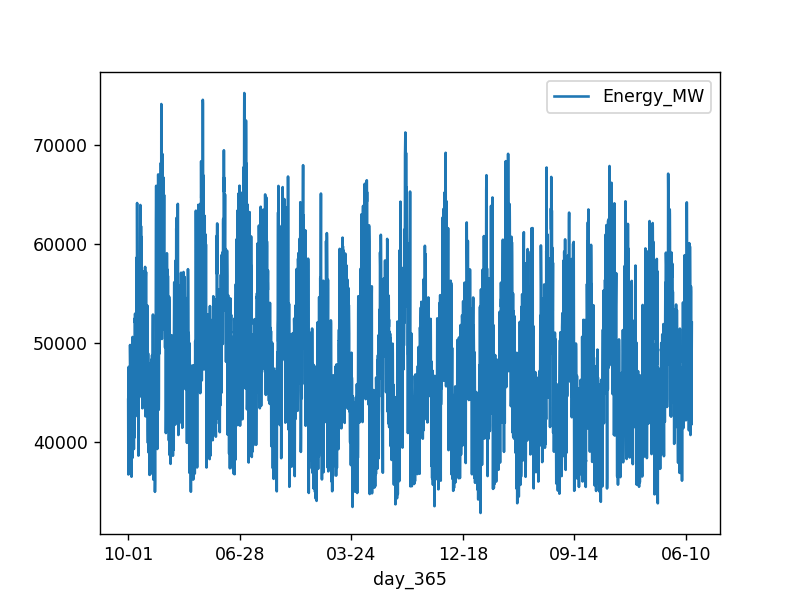

<AxesSubplot: xlabel='day_365'>

In [13]:
df_merge_energy_reasons.plot(x='day_365', y='Energy_MW')

<IPython.core.display.Javascript object>


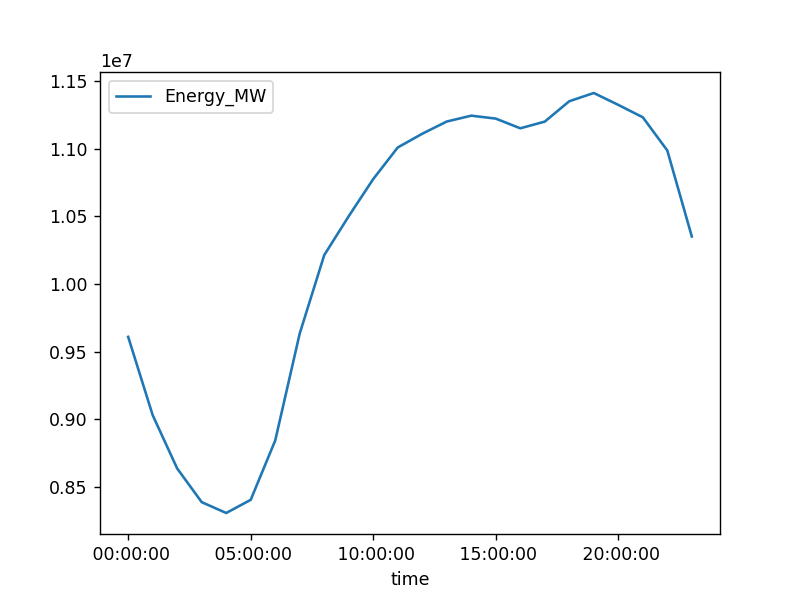

<AxesSubplot: xlabel='time'>

In [14]:
df_energy_time.plot()

<IPython.core.display.Javascript object>


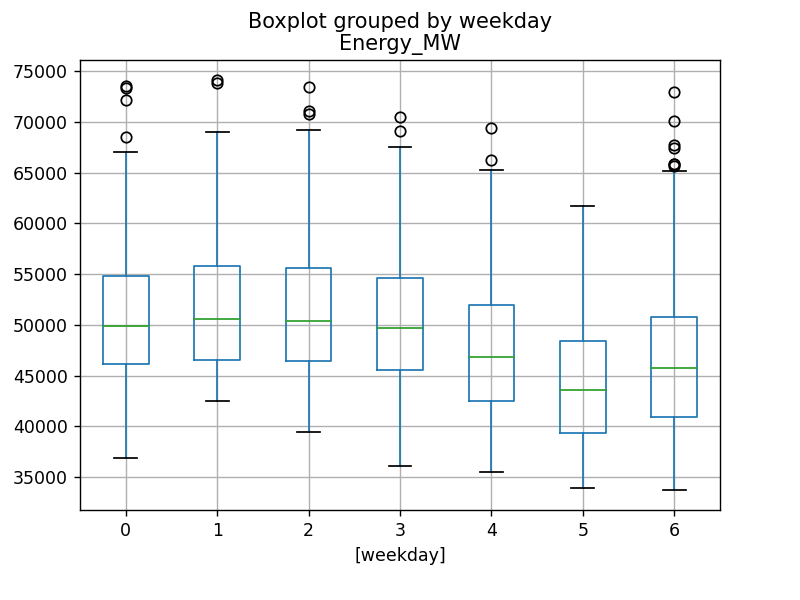

In [15]:
day_in_week = Energy_day_of_week
day_in_week = day_in_week.set_index('Datetime').rolling(24).sum().iloc[::24]
day_in_week['weekday'] = pd.to_datetime(day_in_week.index).weekday
day_in_week.boxplot(by='weekday')
day_in_week = day_in_week.dropna()

<IPython.core.display.Javascript object>


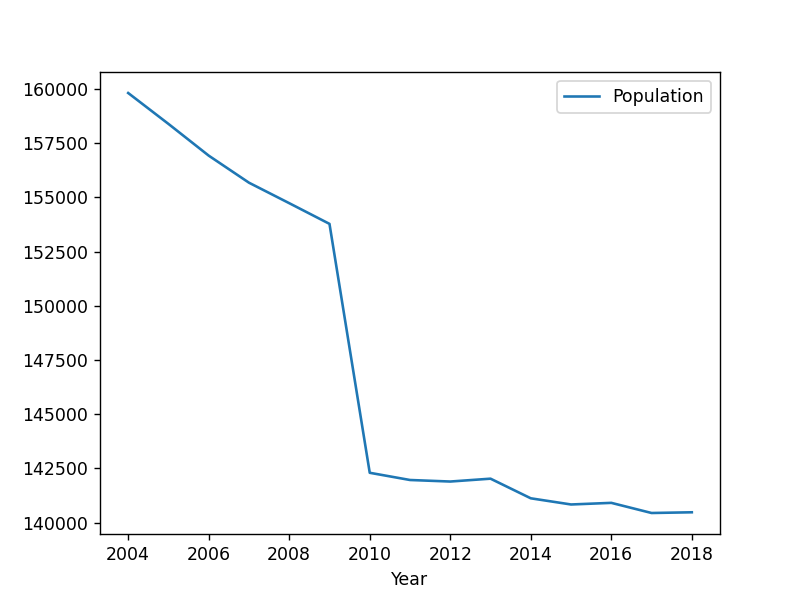

<AxesSubplot: xlabel='Year'>

In [16]:
Dayton_population.plot(x='Year', y='Population')

Widać drastyczny spadek liczby ludności w roku 2009, spowodowany najprawdopodobniej kryzysem finansowym w latach 2007-2009

## Modelowanie

In [17]:
!pip3 install scipy --upgrade

data = df_merge_energy_reasons


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from scipy.stats import permutation_test
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

workdays = data.loc[data['weekday']<5,'Energy_MW']
weekends = data.loc[data['weekday']>=5,'Energy_MW']

p_value = permutation_test((workdays, weekends), statistic,
                           n_resamples=999, alternative='greater')
p_value.pvalue

0.001

Jest bardzo małe prawdopodobieństwo że hipoteza zerowa nie jest spełniona, czyli może istnieć statystyczne prawdopodobieństwo że w dni tygodnia zużycie energi jest większe niż w weekendy

In [19]:
from statsmodels.stats.power import TTestIndPower
effect = (np.mean(workdays) - np.mean(weekends))/((np.std(workdays)+np.std(weekends))/2)

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None, nobs1=min(len(workdays), len(weekends)), ratio=1.0, alpha=0.05)
print(result)

1.0


In [20]:
from scipy.stats import permutation_test
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

mean_humidity = data['humidity'].mean()

low_humidity = data.loc[data['humidity'] <= mean_humidity, 'Energy_MW']
high_humidity = data.loc[data['humidity'] > mean_humidity, 'Energy_MW']

p_value_humidity = permutation_test((high_humidity, low_humidity), statistic, n_resamples=999, alternative='greater')

p_value_humidity.pvalue


0.001

Jest bardzo małe prawdopodobieństwo że hipoteza zerowa nie jest spełniona, czyli może istnieć statystyczne prawdopodobieństwo że wartości mniejsze od średniej wilgotność mają wpływ na zużycie energi

In [21]:
from scipy.stats import permutation_test
def statistic(x, y, axis=0):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

temp_mean = data['temp'].mean()

low_temp = data.loc[data['temp'] <= temp_mean, 'Energy_MW']
high_temp = data.loc[data['temp'] > temp_mean, 'Energy_MW']

p_value_temp = permutation_test((low_temp, high_temp), statistic, n_resamples=999, alternative='greater')

p_value_temp.pvalue

0.002

Jest bardzo małe prawdopodobieństwo że hipoteza zerowa nie jest spełniona, czyli może istnieć statystyczne prawdopodobieństwo że wartości mniejsze od średniej wilgotność mają wpływ na zużycie energi

In [22]:
from scipy.stats import f_oneway
monday = data.loc[data['weekday']==0,'Energy_MW']
tuesday = data.loc[data['weekday']==1,'Energy_MW']
wendsday = data.loc[data['weekday']==2,'Energy_MW']
thursday = data.loc[data['weekday']==3,'Energy_MW']
friday = data.loc[data['weekday']==4,'Energy_MW']
saturday = data.loc[data['weekday']==5,'Energy_MW']
sunday = data.loc[data['weekday']==6,'Energy_MW']
f_value, p_value = f_oneway(monday, tuesday, wendsday, thursday, friday,saturday,sunday)

print(f'F-stat: {f_value}, p-val: {p_value}')

F-stat: 239.658009181396, p-val: 2.8501072697119453e-270


Wyniki testu pokazują że dnia tygodnia mają wpływ na żużycie Energii, a test ANOVA dobrze sprawdza się do porównywania większej grupy danych

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


print(pairwise_tukeyhsd(data['Energy_MW'], data['weekday']))

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     0      1  1103.8476 0.0128   141.0781  2066.6172   True
     0      2  1092.2825 0.0145    129.513  2055.0521   True
     0      3   859.3532 0.1164  -103.4163  1822.1227  False
     0      4  -370.8047 0.9171 -1333.5742   591.9648  False
     0      5 -5877.1177    0.0 -6839.8872 -4914.3482   True
     0      6 -7403.8615    0.0  -8366.631  -6441.092   True
     1      2   -11.5651    1.0  -974.3346   951.2044  False
     1      3  -244.4945 0.9894  -1207.264   718.2751  False
     1      4 -1474.6524 0.0001 -2437.4219  -511.8828   True
     1      5 -6980.9654    0.0 -7943.7349 -6018.1959   True
     1      6 -8507.7091    0.0 -9470.4787 -7544.9396   True
     2      3  -232.9294 0.9918 -1195.6989   729.8402  False
     2      4 -1463.0873 0.0002 -2425.8568  -500.3177   True
     2      5 -6969.4003

Dodatkowo sprawdziłem jeszcze dane korzystając z testu tukeyhsd który porównuje dane między sobą, i doszliśmy do wniosku że istnieje statystycznie istotna różnica między danymi z (wt-sr, pon-czw, pon-pt, wt-sr oraz pon-sr)

In [24]:
from scipy.stats import f_oneway

spring = data.loc[data['season']==1,'Energy_MW']
summer = data.loc[data['season']==2,'Energy_MW']
outumn = data.loc[data['season']==3,'Energy_MW']
winter = data.loc[data['season']==4,'Energy_MW']

f_value, p_value = f_oneway(spring, summer, outumn, winter)

print(f'F-stat: {f_value}, p-val: {p_value}')

F-stat: 616.6537391240399, p-val: 0.0


Wyniki testu nie potwierdzają wpływy pór roku na żużycie Energii

In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


print(pairwise_tukeyhsd(data['Energy_MW'], data['season']))

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     1      2  8130.8966    0.0  7518.5275  8743.2656   True
     1      3   775.6971 0.0065   161.4639  1389.9302   True
     1      4  7063.5225    0.0  6451.6441   7675.401   True
     2      3 -7355.1995    0.0 -7972.8985 -6737.5005   True
     2      4  -1067.374 0.0001 -1682.7316  -452.0165   True
     3      4  6287.8255    0.0  5670.6128  6905.0381   True
------------------------------------------------------------


test tukeyhsd potwierdza wyniku testu ANOVA

In [26]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


print(pairwise_tukeyhsd(data['Energy_MW'], data['month']))

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
     1      2    -970.656 0.4133  -2298.8525   357.5405  False
     1      3  -5880.7834    0.0  -7177.3613 -4584.2055   True
     1      4 -10235.4383    0.0 -11542.7764 -8928.1003   True
     1      5  -8867.9378    0.0 -10164.5157 -7571.3599   True
     1      6  -2128.7002    0.0  -3436.0383  -821.3622   True
     1      7    504.0783 0.9826   -792.4995  1800.6562  False
     1      8   1118.9286 0.1921   -200.6555  2438.5127  False
     1      9  -6123.1634    0.0  -7455.8097 -4790.5171   True
     1     10  -9222.4009    0.0 -10518.9788 -7925.8231   True
     1     11  -7092.3431    0.0  -8399.6811 -5785.0051   True
     1     12  -2736.1935    0.0  -4032.7714 -1439.6157   True
     2      3  -4910.1274    0.0  -6238.3239 -3581.9309   True
     2      4  -9264.7823    0.0 -10603.4848 -7926.0798

In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


print(pairwise_tukeyhsd(df_energy['Energy_MW'], df_energy['part_of_day']))

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     1      2  103.6073   0.0    97.959  109.2556   True
     1      3 -348.2694   0.0 -353.9185 -342.6204   True
     2      3 -451.8768   0.0 -457.5258 -446.2277   True
--------------------------------------------------------


### ZAD1

Podzieliłem zbiór na 2 zbioru jeden do nauczenia modelu a drugi do jego sprawdzenia, wyniki są satysfakcjonujące

In [28]:
data = data.reset_index()
# data.info()

data_learn = data[data['Year'] <= 2017]
data_prediction = data[data['Year'] > 2017]

# print(data_learn)
# print(data_preditions)

In [29]:
from statsmodels.formula.api import ols

model = ols('Energy_MW ~ temp * C(weekday) * C(season) * C(month) * Population + humidity', data=data_learn)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Energy_MW   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     116.0
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        03:18:12   Log-Likelihood:                -44272.
No. Observations:                4840   AIC:                         8.922e+04
Df Residuals:                    4503   BIC:                         9.140e+04
Df Model:                         336                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.124e+04   6259.894      1.795      0.073   -1033.421    2.35e+04
C(weekday)[T.1]                                                7933.3454   8758.592      0.906      0.365   -9237.795    2.51e+04
C(weekday)[T.2]                                                1.509e+04   8902.791      1.695      0.090   -2361.640    3.25e+04
C(weekday)[T.3]                                                -132.9685   9002.004     -0.015      0.988   -1.78e+04    1.75e+04
C(weekday)[T.4]                                                1612.8775   9132.723      0.177      0.860   -1.63e+04    1.95e+04
C(weekday)[T.5]                                                 557.7316   9081.886      0.061      0.951   -1.72e+04    1.84e+04
C(weekday)[T.6]                                               -5217.9528   8768.924     -0.595      0.552   -2.24e+04     1.2e+04
C(season)[T.2]                                                -1.359e+04   1.78e+04     -0.763      0.446   -4.85e+04    2.13e+04
C(season)[T.3]                                                 2.992e+04   9426.902      3.174      0.002    1.14e+04    4.84e+04
C(season)[T.4]                                                 2.379e+04   8222.316      2.894      0.004    7674.377    3.99e+04
C(month)[T.2]                                                 -6832.4083   4656.957     -1.467      0.142    -1.6e+04    2297.514
C(month)[T.3]                                                  2.054e+04   9520.126      2.157      0.031    1875.013    3.92e+04
C(month)[T.4]                                                   480.8442   1.83e+04      0.026      0.979   -3.55e+04    3.64e+04
C(month)[T.5]                                                 -4.991e+04   1.91e+04     -2.614      0.009   -8.73e+04   -1.25e+04
C(month)[T.6]                                                  3.526e+04   2.02e+04      1.743      0.081   -4405.820    7.49e+04
C(month)[T.7]                                                 -3.344e+04   2.49e+04     -1.344      0.179   -8.22e+04    1.53e+04
C(month)[T.8]                                                  -1.54e+04   2.53e+04     -0.608      0.543   -6.51e+04    3.43e+04
C(month)[T.9]                                                  3.625e+04   1.74e+04      2.079      0.038    2074.296    7.04e+04
C(month)[T.10]                                                -3828.9755   8123.896     -0.471      0.637   -1.98e+04    1.21e+04
C(month)[T.11]                                                -2500.4787   6775.199     -0.369      0.712   -1.58e+04    1.08e+04
C(month)[T.12]                                                -2668.6893   4489.603     -0.59

<IPython.core.display.Javascript object>


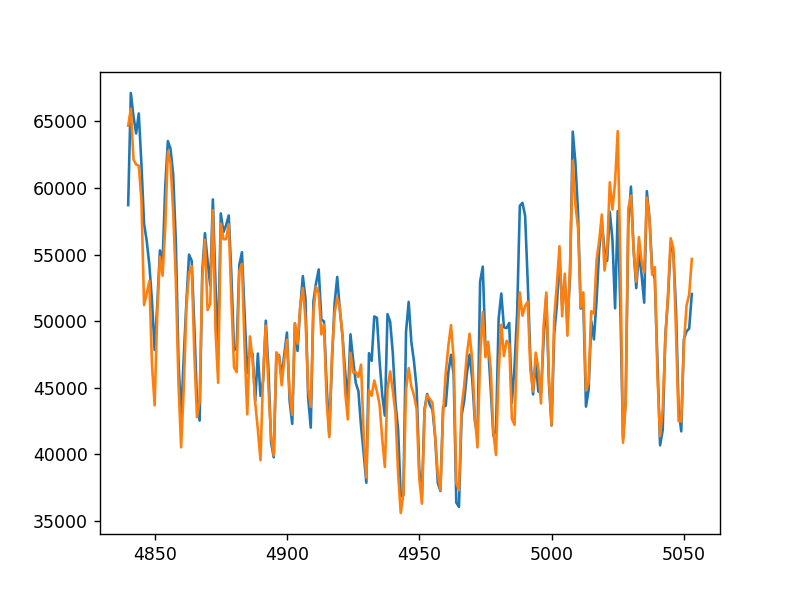

In [30]:
plt.figure()
energy_prediction = res.predict(data_prediction)
data_prediction['Energy_MW'].plot()
plt.plot(data_prediction['Energy_MW'].index, energy_prediction)

### ZAD2 

Podzieliłem zbiór bardzo podobnie jak poprzedni lecz teraz ucze dane na zbiorze nie zawierającego soboty i niedzieli, a następnie sprawdzam jak taki sposób uczenia oddziałuje na ostateczną predykcja dla całego tygodnia

<IPython.core.display.Javascript object>


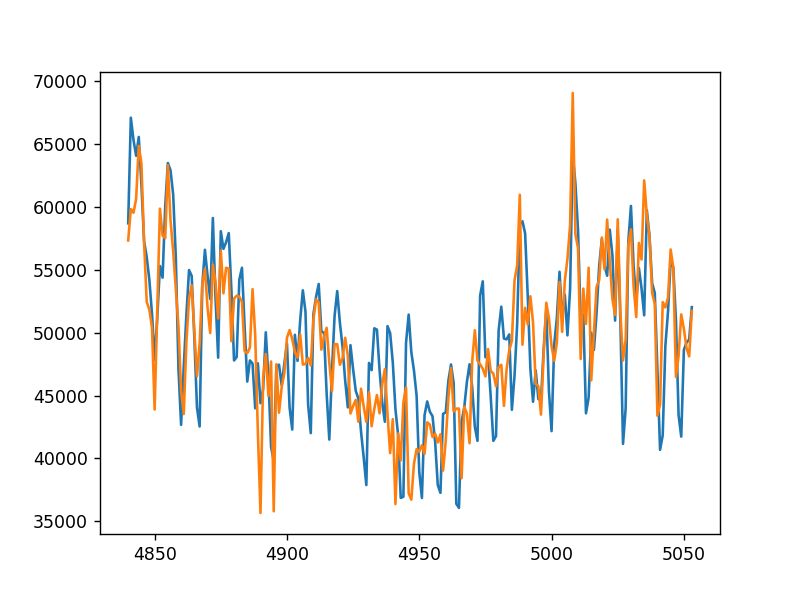

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Energy_MW   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     116.0
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        03:20:14   Log-Likelihood:                -44272.
No. Observations:                4840   AIC:                         8.922e+04
Df Residuals:                    4503   BIC:                         9.140e+04
Df Model:                         336                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.124e+04   6259.894      1.795      0.073   -1033.421    2.35e+04
C(weekday)[T.1]                                                7933.3454   8758.592      0.906      0.365   -9237.795    2.51e+04
C(weekday)[T.2]                                                1.509e+04   8902.791      1.695      0.090   -2361.640    3.25e+04
C(weekday)[T.3]                                                -132.9685   9002.004     -0.015      0.988   -1.78e+04    1.75e+04
C(weekday)[T.4]                                                1612.8775   9132.723      0.177      0.860   -1.63e+04    1.95e+04
C(weekday)[T.5]                                                 557.7316   9081.886      0.061      0.951   -1.72e+04    1.84e+04
C(weekday)[T.6]                                               -5217.9528   8768.924     -0.595      0.552   -2.24e+04     1.2e+04
C(season)[T.2]                                                -1.359e+04   1.78e+04     -0.763      0.446   -4.85e+04    2.13e+04
C(season)[T.3]                                                 2.992e+04   9426.902      3.174      0.002    1.14e+04    4.84e+04
C(season)[T.4]                                                 2.379e+04   8222.316      2.894      0.004    7674.377    3.99e+04
C(month)[T.2]                                                 -6832.4083   4656.957     -1.467      0.142    -1.6e+04    2297.514
C(month)[T.3]                                                  2.054e+04   9520.126      2.157      0.031    1875.013    3.92e+04
C(month)[T.4]                                                   480.8442   1.83e+04      0.026      0.979   -3.55e+04    3.64e+04
C(month)[T.5]                                                 -4.991e+04   1.91e+04     -2.614      0.009   -8.73e+04   -1.25e+04
C(month)[T.6]                                                  3.526e+04   2.02e+04      1.743      0.081   -4405.820    7.49e+04
C(month)[T.7]                                                 -3.344e+04   2.49e+04     -1.344      0.179   -8.22e+04    1.53e+04
C(month)[T.8]                                                  -1.54e+04   2.53e+04     -0.608      0.543   -6.51e+04    3.43e+04
C(month)[T.9]                                                  3.625e+04   1.74e+04      2.079      0.038    2074.296    7.04e+04
C(month)[T.10]                                                -3828.9755   8123.896     -0.471      0.637   -1.98e+04    1.21e+04
C(month)[T.11]                                                -2500.4787   6775.199     -0.369      0.712   -1.58e+04    1.08e+04
C(month)[T.12]                                                -2668.6893   4489.603     -0.59

In [31]:
zad2 = data

# print(zad2)
# zad2.info()
model_zad2 = zad2[(zad2['Year'] <= 2017) & (zad2['weekday'] < 6)]
pred_zad2 = zad2[(zad2['Year'] > 2017)]


model2 = ols('Energy_MW ~ temp * Population * C(season) * day_365 + humidity', data = model_zad2)
res2 = model2.fit()
res2.summary()
energy_prediction2 = res2.predict(pred_zad2)
plt.figure()
pred_zad2['Energy_MW'].plot()
plt.plot(pred_zad2['Energy_MW'].index, energy_prediction2)
res.summary()

### ZAD3

Naczułem model na danych do 14.12.2015 roku, podobnie jak w zadaniu 1 lecz teraz miałem mniejszą ilość danych, o wyniki wyszły znacznie gorsze

<IPython.core.display.Javascript object>


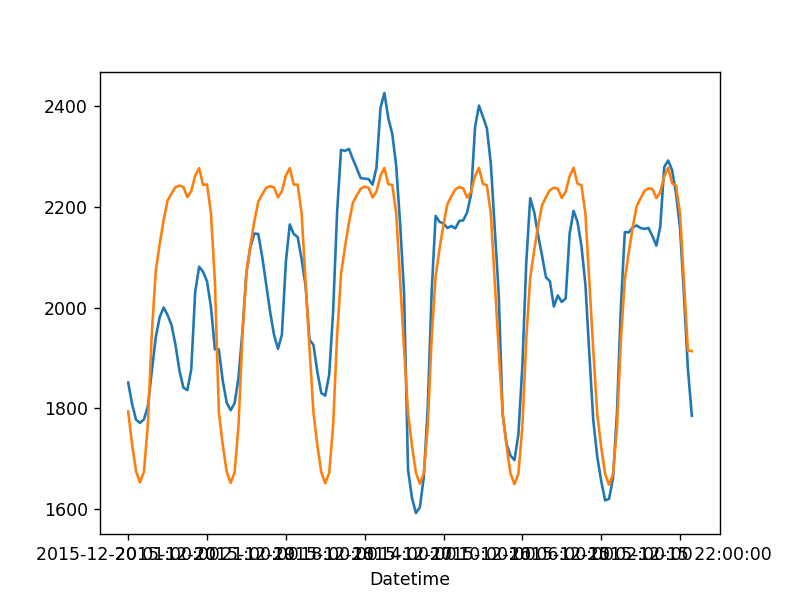

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Energy_MW   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     116.0
Date:                Sat, 21 Jan 2023   Prob (F-statistic):               0.00
Time:                        03:20:17   Log-Likelihood:                -44272.
No. Observations:                4840   AIC:                         8.922e+04
Df Residuals:                    4503   BIC:                         9.140e+04
Df Model:                         336                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.124e+04   6259.894      1.795      0.073   -1033.421    2.35e+04
C(weekday)[T.1]                                                7933.3454   8758.592      0.906      0.365   -9237.795    2.51e+04
C(weekday)[T.2]                                                1.509e+04   8902.791      1.695      0.090   -2361.640    3.25e+04
C(weekday)[T.3]                                                -132.9685   9002.004     -0.015      0.988   -1.78e+04    1.75e+04
C(weekday)[T.4]                                                1612.8775   9132.723      0.177      0.860   -1.63e+04    1.95e+04
C(weekday)[T.5]                                                 557.7316   9081.886      0.061      0.951   -1.72e+04    1.84e+04
C(weekday)[T.6]                                               -5217.9528   8768.924     -0.595      0.552   -2.24e+04     1.2e+04
C(season)[T.2]                                                -1.359e+04   1.78e+04     -0.763      0.446   -4.85e+04    2.13e+04
C(season)[T.3]                                                 2.992e+04   9426.902      3.174      0.002    1.14e+04    4.84e+04
C(season)[T.4]                                                 2.379e+04   8222.316      2.894      0.004    7674.377    3.99e+04
C(month)[T.2]                                                 -6832.4083   4656.957     -1.467      0.142    -1.6e+04    2297.514
C(month)[T.3]                                                  2.054e+04   9520.126      2.157      0.031    1875.013    3.92e+04
C(month)[T.4]                                                   480.8442   1.83e+04      0.026      0.979   -3.55e+04    3.64e+04
C(month)[T.5]                                                 -4.991e+04   1.91e+04     -2.614      0.009   -8.73e+04   -1.25e+04
C(month)[T.6]                                                  3.526e+04   2.02e+04      1.743      0.081   -4405.820    7.49e+04
C(month)[T.7]                                                 -3.344e+04   2.49e+04     -1.344      0.179   -8.22e+04    1.53e+04
C(month)[T.8]                                                  -1.54e+04   2.53e+04     -0.608      0.543   -6.51e+04    3.43e+04
C(month)[T.9]                                                  3.625e+04   1.74e+04      2.079      0.038    2074.296    7.04e+04
C(month)[T.10]                                                -3828.9755   8123.896     -0.471      0.637   -1.98e+04    1.21e+04
C(month)[T.11]                                                -2500.4787   6775.199     -0.369      0.712   -1.58e+04    1.08e+04
C(month)[T.12]                                                -2668.6893   4489.603     -0.59

In [32]:
zad3 = df_energy
zad3 = zad3.reset_index()
zad3 = zad3.set_index('daty')
# zad3.info()
zad3['year'] = pd.to_datetime(zad3.index).year
zad3['month'] = pd.to_datetime(zad3.index).month
zad3['day'] = pd.to_datetime(zad3.index).day



model_zad3 = zad3[(zad3['year'] <= 2015) & (zad3['month'] <= 12) & (zad3['day'] <= 14)]
pred_zad3 = zad3[(zad3['year'] == 2015) & (zad3['month'] == 12) & (zad3['day'] <= 20) & (zad3['day'] > 14)]

pred_zad3 = pred_zad3.reset_index()
pred_zad3 = pred_zad3.set_index('Datetime')

model3 = ols('Energy_MW ~ C(part_of_day) * C(time) * day', data = model_zad3)
res3 = model3.fit()
res3.summary()
energy_prediction3 = res3.predict(pred_zad3)
plt.figure()
pred_zad3['Energy_MW'].plot()
plt.plot(pred_zad3['Energy_MW'].index, energy_prediction3)
res.summary()